In [2]:
# Main use case: relatively easy to gather data -> requires a lot of effort to label it (human input)
# different tasks of unsuervised learning:
# 1) Clustering - group similar instances together in clusters
# 2) Anomaly detection - objective: learn what "normal" data looks like, and use it to detect abnormal instances
# 3) Density estimation - estimate the probability density function (PDF) of the random process that generated the dataset
# - can be used for anomaly detection - instances in very low-dimensity regions are likely to be abnormalities
# 4) Dimensionality reduction - explained in chapter 8

In [3]:
# Clustering
# - identifying similar instances and assigning them to clusters even if you don't exactly know what they are

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [5]:
# Let's have a look at iris data set
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

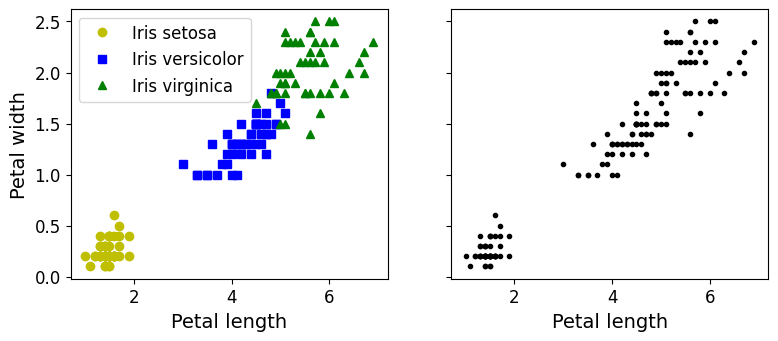

In [6]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

In [7]:
# On the left - labelled dataset, right - unlabelled: not easy to see that the top part is actually composed of 2 sub-clusters

# Clustering application:
# - customer segmentation - understanding who your customers are and what they need -> adapt products and marketing (recommendation system)
# - data analysis - with new dataset, often useful to first discover clusters of similar instances
# - dimensionality reduction technique - one clusters have been identified -> possible to measure each instance's affinity with each cluster
#  -> then each instance's feature vector can be replaced with the vector of its cluster affinities -> typically decreases dimensionality while perserving info
# - anomaly/outlier detection - any instance that has a low affinity for all clusters -> likely to be an anomaly
# - semi-supervised learning - if you only have a few labels -> clustering can help propagate the labels to all instances in the same cluster
# - search engines - reverse seraching an image - need to apply a clustering algorithm to all images - similar images end up in the same cluster
# - image segmentation - clustering pixels according to their color and then replacing pixel's colors with the mean of its cluster
#  -> reduces the numbers of colors significantly - makes it easier to detect the contour of each object

In [8]:
# K-Means algorithm
# - requires to specify the numer of clusters k that the algorithm has to find

# How does it work?
# - start by placing the centroids randomly -> label instances (by finding the closest centroid) -> update the centroids -> repeat
# - the centroids are updated to be the mean of the instances that are assigned to them
# - guaranteed to converge in a finite number of steps (usually small) but might not converge to the right solution (gets stuck in a local optimum)
#   - depends on the centroid initialization
# - comp. complexity - usually linear with regards to number of instances m, number of clusters k and the number of dimensions n (only true for data with clustering structure)

In [9]:
# Example:
from sklearn.datasets import make_blobs

# generate data
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [10]:
# Plot data
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

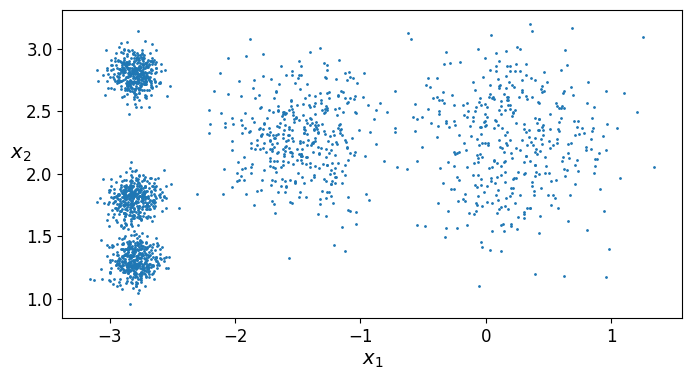

In [11]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [12]:
# trining K-Means clusterer
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [13]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

In [14]:
y_pred is kmeans.labels_

True

In [15]:
# Getting cluster centroids
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

In [16]:
# Can show labels for all instances
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

In [17]:
# Can make predictions on new instances
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

In [18]:
# Plotting decision boundaries
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

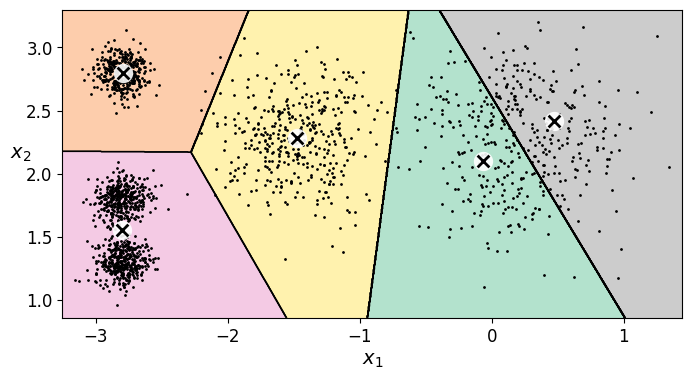

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [20]:
# As you can see - it algorithm didnt converge to an optimal solution - lets give it a few more tries

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=0)

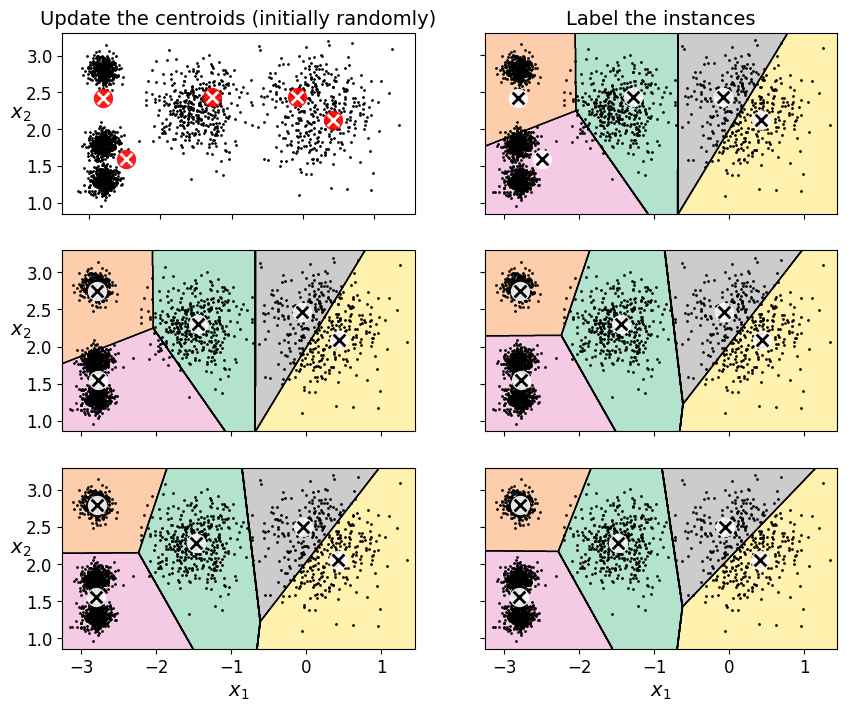

In [21]:
# plotting everything
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

In [22]:
# By using multiple initializations - the algorithm can converge to different solutions
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

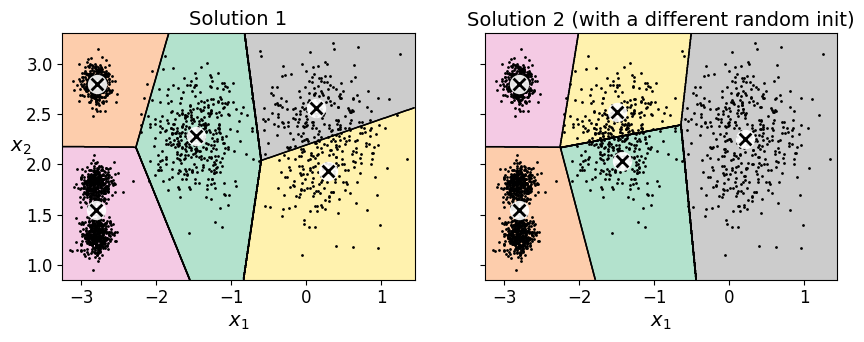

In [23]:
# Showing K-Means variability:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

In [24]:
# Hard Clustering vs Soft Clustering:
# - hard: choosing the closest cluster for an instance
# - soft: measuring the distance to all 5 centroids

# done with the transform() method
kmeans.transform(X_new)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

In [25]:
# verify that it is indeed the Euclidian distance between each instance and each centroid:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

In [26]:
# Inertia - allows us to evaluate the model
# - we dont have targets (unsupervised task) but at least we can measure the distance between each instance and its centroid

# Is the sum of the squared distances between each training instance and its closest centroid
kmeans.inertia_

224.07433122515724

In [27]:
# Verify:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

np.float64(224.07433122515693)

In [28]:
# score() method returns negative inertia - it respects greater is better rule
kmeans.score(X)

-224.07433122515727

In [29]:
# Do multiple initializations
print(kmeans_rnd_init1.inertia_)
print(kmeans_rnd_init2.inertia_)

219.58201503602282
239.19226403410457


In [30]:
# In SL - n_init hyperparam can be set that runs the algorithm n_init times, and selects the solutions that minimizes the intertia
# - default is 10:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="lloyd", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

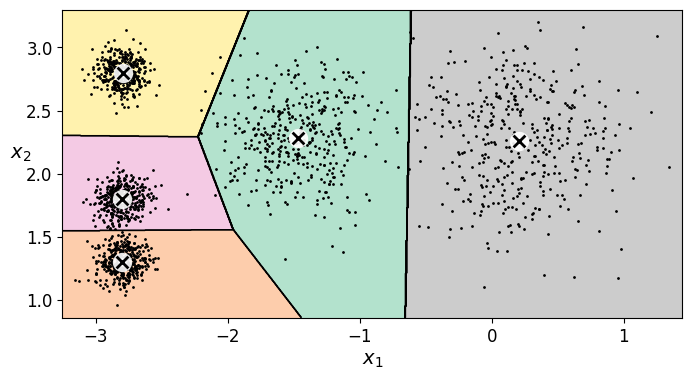

In [31]:
# Seems a lot better than just 1 random initialization
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [32]:
# Centroid Initialization Methods
# - how to find the best starting point to find the glabally optimal solution

In [33]:
# If you know approx where the centroids should be - can set the init hyperparameter to a NumPy array containing the list of centroids:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

In [34]:
# An improvement to K-Means algorithm: K-Means+\+ - introduced in 2006 by David Arthur and Sergei Vassilvitskii
# - smarter initialization step: selects centroids that ae distant from one another -> much more less likely to converge to less optimal solution
# - additional computation step is well worth - reduces the number of times the algorithm needs to be run to find the optimal solution

# K-Means++ initialization algo:
# 1) Take one centroid, chosen unofrmly at random from the dataset
# 2) Take a new centroid by choosing an instance x with certain prob. (p. 245) with the distance between the instance x and the closest centroid already chosen
# - prob. distribution ensures that instances further away from already chosen centroids are much more likely to be selected as centroids
# 3) Repeat 2) until all k centroids have been chosen

# KMeans class uses this initialization method by default. To force it to use the original matehod - set init="random" (rarely needed)
# - can be explicitly set as: init="k-means++"

In [35]:
# Accelerated K-Means 
# avoids many unecnecessary distance calculations:
# - exploiting triangle inequality, i.e. straight lines are always the shortest
# - keeps track of lower and upper bounds for distances between centroids
# set in KMeans class by setting the algorithm hyperparam to "elkan" 

In [36]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

4.87 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [37]:
%timeit -n 50 KMeans(algorithm="lloyd", random_state=42).fit(X)

7 ms ± 121 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [38]:
# Mini-batch K-Means
# uses mini-batches of dataset instead of full one
# - moves centroids just slightly at each itteration
# -> speeds up the algorithm by 3/4 times and makes it possible to cluster huge datasets that do not fit in memory
# SL - MiniBatchKMeans class

In [39]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

minibatch_kmeans.inertia_

211.6594510571261

In [40]:
# When the dataset does not fit memmory - use memmap class (just like for incremental PCA)
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

In [41]:
# Save the data using memmap
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [44]:
# Function to load the data
def load_next_batch(batch_size):
    # In real example - load from disk
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [45]:
np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [46]:
best_kmeans.score(X)

-211.6212358403339

In [47]:
# Mini-batch - much faster than regular K-Means
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

7.69 ms ± 322 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
60.3 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
# Minibatch is supposed to be much faster, but its performance is often lower (higher inertia) + it keeps degrading as k increases
# lets plot inertia ratio and the training time ratio
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

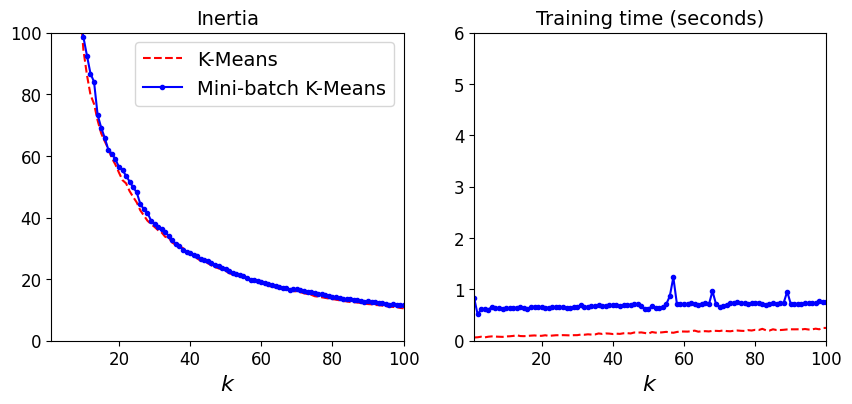

In [49]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

In [50]:
# Finding the optimal number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

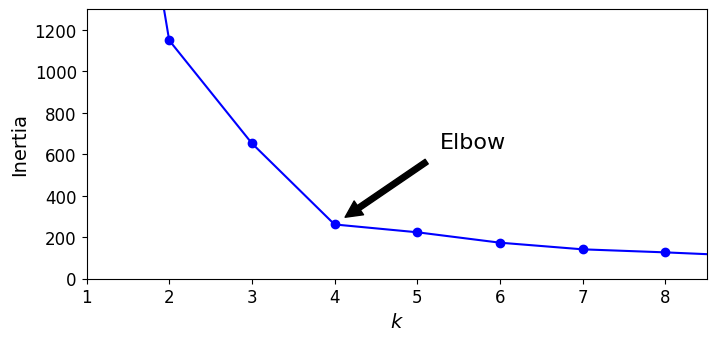

In [51]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

In [52]:
# Above plot: Inertia as a function of k
# - sharp dearease as k increases to 4, then the decrease is a lot smaller
# - good approach but rather coarse - here it would suggest there are 4 clusters when we know it should be 5

# Another approach - silhouetter score - mean silhouette coefficient over all instances (more computationally expensive)
# - silhouette coefficienct = (b-a)/max(a,b): 
# -- a - mean distance to the other instances in the same cluster, b - mean nearest-cluster distance (distances to the instances of the next closest cluster)
# - varies between -1 and 1 (1 - instance well inside tits own cluster and away from others, -1 - instance may be in the wrong cluster, 0 - at the border)

# SL - has silhouette_score() function 

In [53]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

In [54]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

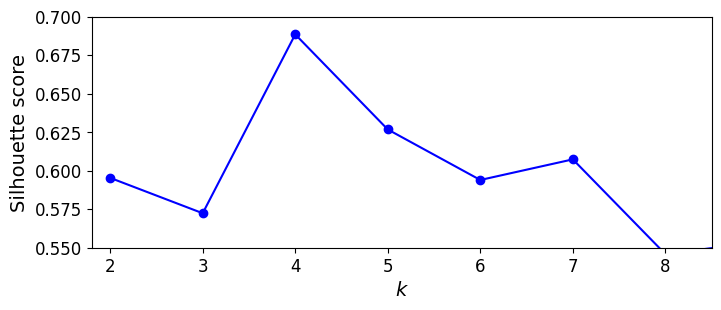

In [55]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [56]:
# Still confirms that K=4 is still a good score, it also shows that 5 is still good candidate better than 6/7 (not visible with inertia)

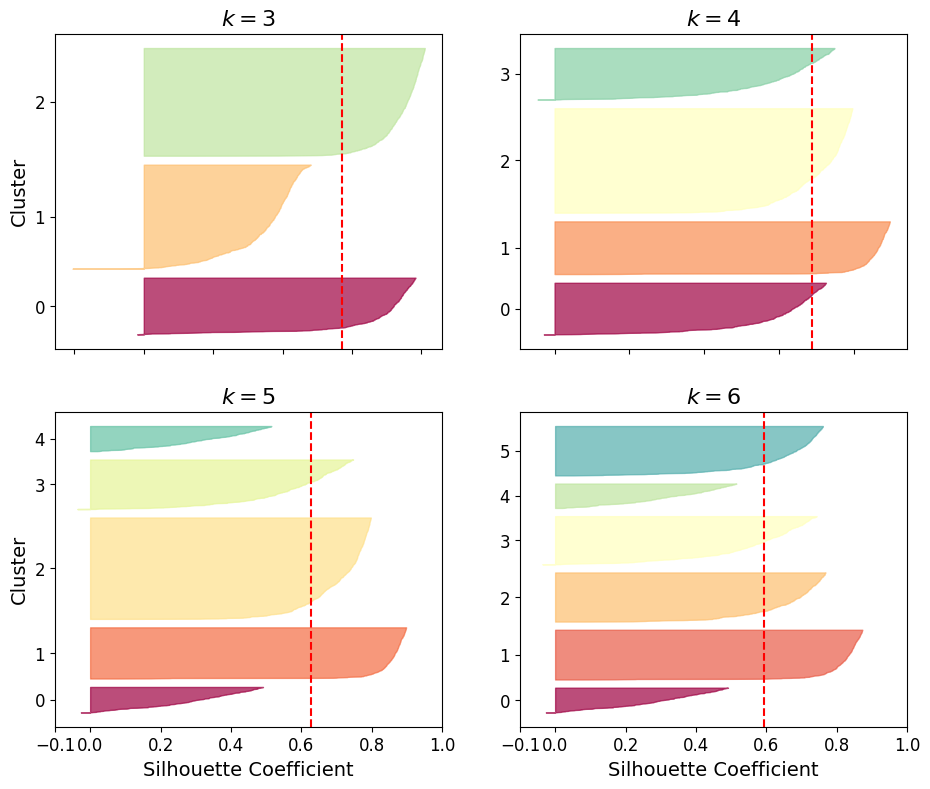

In [57]:
# Can also create a silhouette diagram - plot every instance's silhouette coefficient, sorted by the cluster they are assigne to
# - called silhouette diagram:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [58]:
# Vertical dashed line - silhouette score for each number of clusters
# When most instances in a cluster have a lower coefficient than this score  - cluster is rather bad (instances are much to close to other clusters)

# e.g. at k=3 & 6 - we get a bad clusters but for k=4 seems quite good

In [59]:
# Limits of K-Means
# - needs to be run multiple times to avoid sub-optimal solutions
# - need to specify the number of clusters in advance
# - troubles when clusters have varying sizes, different densities, or non-spherical shapes

In [60]:
# Example: dataset containing three ellipsoidal clusters of different dimensions, densities and orientation:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

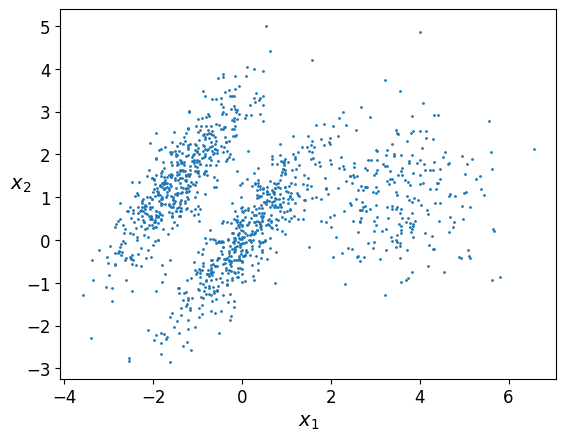

In [61]:
plot_clusters(X)

In [62]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_good.fit(X)

KMeans(init=array([[-1.5,  2.5],
       [ 0.5,  0. ],
       [ 4. ,  0. ]]),
       n_clusters=3, n_init=1, random_state=42)

In [63]:
kmeans_bad = KMeans(n_clusters=3)
kmeans_bad.fit(X)

KMeans(n_clusters=3)

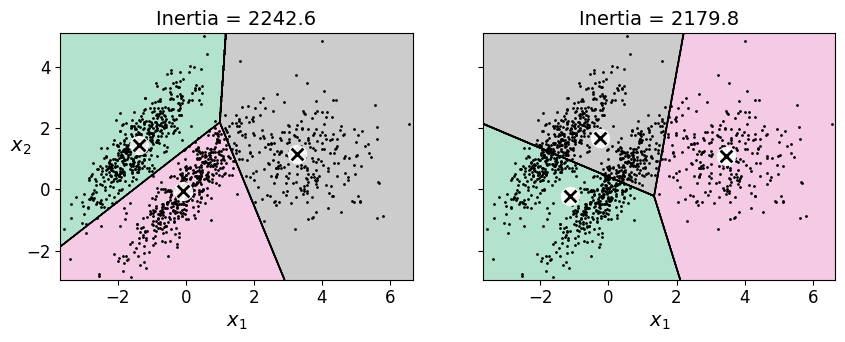

In [64]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

In [65]:
# Neither of the two solutions are any good
# Left is better, but still chops off 25% of the middle cluster and assigns is to the cluster on the right
# Right - terrible, even though it has lower inertia
# -> Depending on the data, different clusstering algorithms may perform better:
#    e.g. on these types of elliptical clusters - Gaussian mixture models work great

# Also important: to scale input features before you run K-Means, otherwise the clusters may be very stretched (not perfect solution, but it does improve it)

In [66]:
# Benefits from Clustering: 1) Image segmentation:
# Image segmentation - all pixels of the same object type get assigned to the same segment
# Instance segmentation - all pixels that are a part of the same individual object are assigned to the same segment, e.g. different segment for each pedestrian

# For now: Colour segmentation (more advanced techniues, e.g. CNN, later)
# - assign pixels to the same segment if they have a similar colour - for some applications this might be good enough

In [67]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x18989536090>)

In [68]:
# Load the image
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [71]:
# 3D array: height, width, number of colour channels (RGB)

# First reshape the array to get a long list of RGB colours, and then cluster these using K-Means
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
# reshape it back to the original image
segmented_img = segmented_img.reshape(image.shape)

In [72]:
# Experimenting with the number of clusters:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

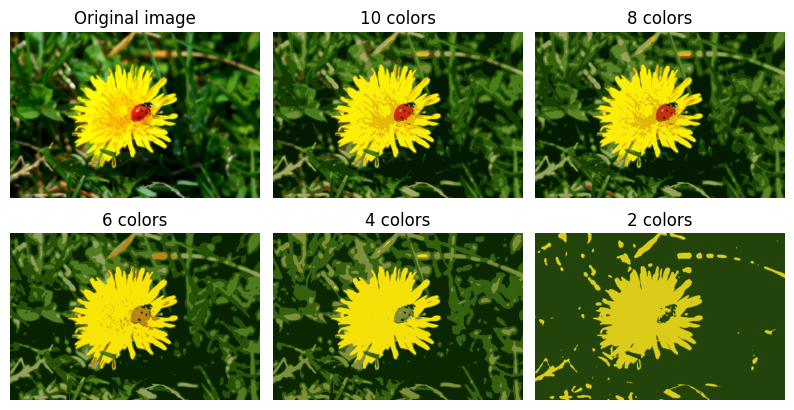

In [73]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

In [74]:
# Using less than 8 clusters - ladybug's red colour fails to get a cluster of its own
# - lady bug is quite small, so even tho the colour is flashy, K-Means fails to assing a cluster to it (prefers clusters of similar sizes)

In [75]:
# 2) Clustering for Preprocessin
# - can be efficient approach to dimensionality reduction, e.g. as a preprocessing step before a supervised learning algorith,

# Example on digits data set (MNIST-like)

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [76]:
# Split it to training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [77]:
# Fit a Logistic Regression model:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [78]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

In [79]:
# Above is a baseline, obtained by using only supervised learning, lets see if we can improve it using K-Means
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [80]:
# Tempting to put 10 as the number of clusters, but the same digit can be written different ways, so using more clusters performs better 
Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [81]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.98

In [82]:
# How much did the error drop?
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.3571428571428561

In [83]:
# Error was reduced by over 35%! with arbitrarily chosen number of clusters
# Can we do better? Of course, and analysis is a lot simpler than before - just asses the used k based on classification performance
# (no need for silhouette analysis or minimization of inertia) -> use GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=6; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=6; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

[CV] END ...............................kmeans__n_clusters=6; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=7; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=7; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=7; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=8; total time=   0.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=9; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

[CV] END ...............................kmeans__n_clusters=9; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=9; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=10; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=11; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   0.2s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   1.1s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   0.8s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   1.0s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   0.6s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   0.7s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.5s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.4s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.3s


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [84]:
grid_clf.best_params_

{'kmeans__n_clusters': 77}

In [85]:
grid_clf.score(X_test, y_test)

0.9844444444444445

In [86]:
1 - (1 - grid_clf.score(X_test, y_test)) / (1 - pipeline_score)

0.22222222222222343

In [87]:
# 22% increase to the arbitraty selected k, compared to the "optimal" one using GridSearch